In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import plot_importance

In [2]:
df = pd.read_csv('features_cleaned.csv')

## Convert categorical variables into dummy/indicator variables

In [3]:
categorical = ['Species']

for var in categorical:
    df = pd.concat([df, pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Zero_Crossings          463 non-null    float64
 1   Duration                463 non-null    float64
 2   Amp_range               463 non-null    float64
 3   Avg_amp                 463 non-null    float64
 4   Freq_range              463 non-null    float64
 5   Pulses_per_Sec          463 non-null    float64
 6   Partials                463 non-null    float64
 7   MFCC                    463 non-null    float64
 8   Spectral Rolloff        463 non-null    float64
 9   Melspectrogram          463 non-null    float64
 10  Spectral Contrast       463 non-null    float64
 11  Chroma_StFt             463 non-null    float64
 12  Tonnetz                 463 non-null    float64
 13  Sex                     463 non-null    object 
 14  Age                     463 non-null    ob

# Vocalization Classification

## Splitting data

In [4]:
X = df[pd.notnull(df['Call'])].drop(['Call','Species_A. jubatus',
       'Species_Bobcat', 'Species_C. temminckii', 'Species_Caracal Carcal',
       'Species_Domestic Cat', 'Species_L. lynx', 'Species_L. serval',
       'Species_Ocelot', 'Species_Wildcat','Freq_range','Avg_amp','Sex','Age'], axis=1)
y = df[pd.notnull(df['Call'])]['Call']

In [5]:
print(X.shape)
print(y.shape)

(444, 11)
(444,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [7]:
print(X_train.shape)
print(X_test.shape)

(310, 11)
(134, 11)


In [8]:
print('Call values for Data')
print(df['Call'].value_counts())
print('\n')
print('Call values for Training')
print(y_train.value_counts())
print('\n')
print('Call values for Testing')
print(y_test.value_counts())

Call values for Data
growl         233
call          106
hiss           63
roar           12
purr           11
mew             9
growl/hiss      6
call/growl      4
Name: Call, dtype: int64


Call values for Training
growl         158
call           81
hiss           42
purr           10
roar            8
mew             6
growl/hiss      3
call/growl      2
Name: Call, dtype: int64


Call values for Testing
growl         75
call          25
hiss          21
roar           4
growl/hiss     3
mew            3
call/growl     2
purr           1
Name: Call, dtype: int64


In [9]:
print('Calls trained for but not tested for')
print(set(np.unique(y_train))-set(np.unique(y_test)))
print('Calls test for but not trained for')
print(set(np.unique(y_test))-set(np.unique(y_train)))

Calls trained for but not tested for
set()
Calls test for but not trained for
set()


In [10]:
## LightGBM

In [11]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train)

LGBMClassifier()

In [12]:
lgb.score(X_train, y_train)

1.0

In [13]:
lgb.score(X_test,y_test)

0.7686567164179104

## XGBoost

In [14]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')


clf = XGBClassifier(**parameters, n_estimators=1200)

In [15]:
clf.fit(X_train, y_train)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [16]:
clf.score(X_train, y_train)

1.0

In [17]:
clf.score(X_test,y_test)

0.7761194029850746

In [18]:
y_pred = clf.predict(X_test)

In [19]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred)))

1. Tested Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
2. Predicted Calls
['call' 'growl' 'hiss' 'mew' 'purr']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'roar', 'growl/hiss', 'call/growl'}


Accuracy 0.7761194029850746


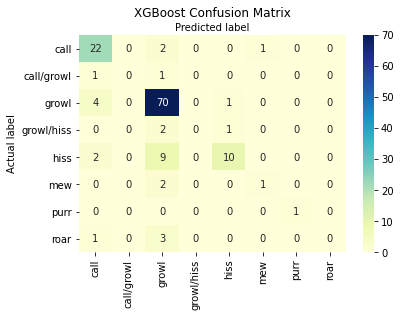

In [20]:
names = sorted(list(set(np.unique(y_test)).union(set(y_pred))))

print('Accuracy',clf.score(X_test, y_test))

cnf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

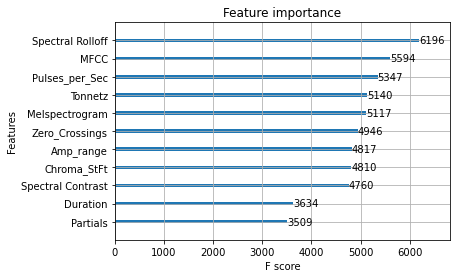

In [21]:
plot_importance(clf)
figsize=(5,10)

## SVM

In [22]:
clf_svc = SVC()

In [23]:
clf_svc.fit(X_train, y_train)

SVC()

In [24]:
clf_svc.score(X_train, y_train)

0.5580645161290323

In [25]:
clf_svc.score(X_test, y_test)

0.582089552238806

In [26]:
y_pred_svc=clf_svc.predict(X_test)

In [27]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_svc))
print('3. False Positive')
print(set(np.unique(y_pred_svc))-set(np.unique(y_test)))
print('4. False Negative')
print(set(np.unique(y_test))-set(np.unique(y_pred_svc)))

1. Tested Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
2. Predicted Calls
['call' 'growl' 'hiss']
3. False Positive
set()
4. False Negative
{'call/growl', 'purr', 'growl/hiss', 'mew', 'roar'}


Accuracy 0.582089552238806


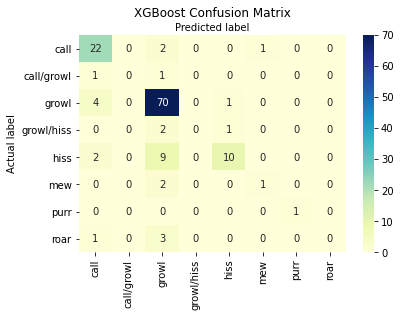

In [28]:
names = sorted(list(set(np.unique(y_test)).union(set(y_pred_svc))))

print('Accuracy',clf_svc.score(X_test, y_test))

cnf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Naive Bayes

In [29]:
gnb = GaussianNB()

In [30]:
gnb.fit(X_train, y_train)

GaussianNB()

In [31]:
gnb.score(X_train, y_train)

0.5612903225806452

In [32]:
gnb.score(X_test, y_test)

0.5149253731343284

In [33]:
y_pred_nb = gnb.predict(X_test)

In [34]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_nb))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_nb))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_nb)))

1. Tested Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
2. Predicted Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


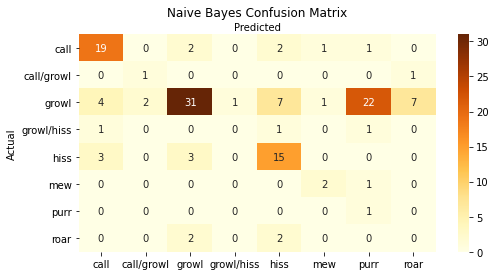

Accuracy 0.5149253731343284


In [35]:
names_nb = sorted(list(set(np.unique(y_test)).union(set(y_pred_nb))))
cnf = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
print('Accuracy',gnb.score(X_test, y_test))

## Logistic Regression

In [36]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight="balanced")

In [37]:
lr.fit(X_train,y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [38]:
lr.score(X_train, y_train)

0.6806451612903226

In [39]:
lr.score(X_test, y_test)

0.7238805970149254

In [40]:
y_pred_lr = lr.predict(X_test)

In [41]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_lr))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_lr))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_lr)))

1. Tested Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
2. Predicted Calls
['call' 'growl' 'hiss']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'call/growl', 'purr', 'growl/hiss', 'mew', 'roar'}


Accuracy 0.7238805970149254


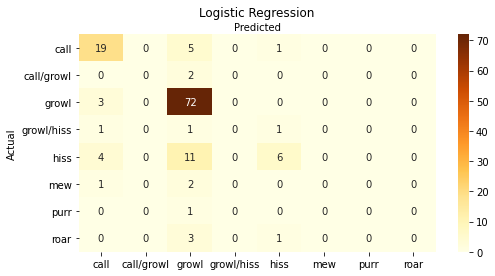

In [42]:
names_lr = sorted(list(set(np.unique(y_test)).union(set(y_pred_lr))))
cnf = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## KNN

In [43]:
knn = KNeighborsClassifier()

In [44]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [45]:
knn.score(X_train, y_train)

0.7935483870967742

In [46]:
knn.score(X_test, y_test)

0.7686567164179104

In [47]:
y_pred_knn = knn.predict(X_test)

In [48]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_knn))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_knn))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_knn)))

1. Tested Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
2. Predicted Calls
['call' 'growl' 'hiss' 'mew' 'purr']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'roar', 'growl/hiss', 'call/growl'}


Accuracy 0.7686567164179104


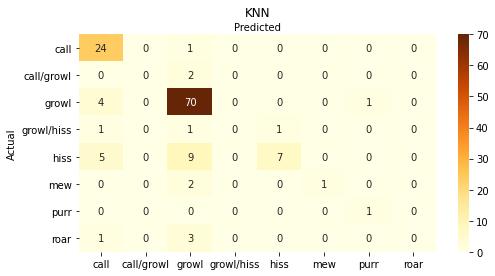

In [49]:
names_knn = sorted(list(set(np.unique(y_test)).union(set(y_pred_knn))))
cnf = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [50]:
cart = DecisionTreeClassifier()

In [51]:
cart.fit(X_train, y_train)

DecisionTreeClassifier()

In [52]:
cart.score(X_train, y_train)

1.0

In [53]:
cart.score(X_test, y_test)

0.6492537313432836

In [54]:
y_pred_cart = cart.predict(X_test)

In [55]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_cart))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_cart))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_cart)))

1. Tested Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
2. Predicted Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.6492537313432836


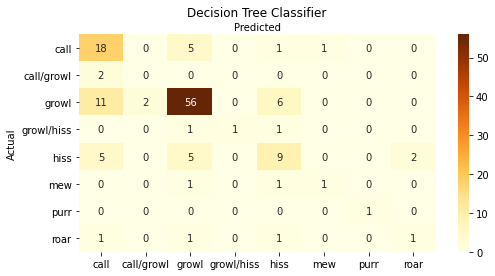

In [56]:
names_cart = sorted(list(set(np.unique(y_test)).union(set(y_pred_cart))))
cnf = confusion_matrix(y_test, y_pred_cart)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',cart.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [57]:
rf = RandomForestClassifier()

In [58]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [59]:
rf.score(X_train, y_train)

1.0

In [60]:
rf.score(X_test, y_test)

0.7910447761194029

In [61]:
y_pred_rf = cart.predict(X_test)

In [62]:
print('1. Tested Calls')
print(np.unique(y_test))
print('2. Predicted Calls')
print(np.unique(y_pred_rf))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_rf))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_rf)))

1. Tested Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
2. Predicted Calls
['call' 'call/growl' 'growl' 'growl/hiss' 'hiss' 'mew' 'purr' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.7910447761194029


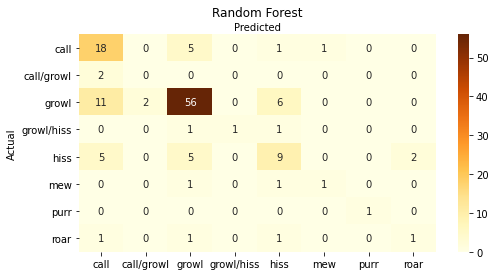

In [63]:
names_rf = sorted(list(set(np.unique(y_test)).union(set(y_pred_rf))))
cnf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [64]:
#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df['Call'].value_counts()

growl         233
call          106
hiss           63
roar           12
purr           11
mew             9
growl/hiss      6
call/growl      4
Name: Call, dtype: int64

# Species Classification

In [65]:
df2= pd.read_csv('features_cleaned.csv')

In [66]:
df2.head()

,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,Partials,MFCC,Spectral Rolloff,Melspectrogram,Spectral Contrast,Chroma_StFt,Tonnetz,Sex,Age,Species,Call
0,-0.756087,-0.878539,-0.592361,-0.171969,-1.178824,-0.580445,-0.564186,0.768646,-1.071521,0.101744,18.307605,0.734437,-0.006876,Unknown,Adult,A. jubatus,growl
1,-0.460687,-0.054575,0.830625,0.922331,-0.266729,-0.296893,1.305172,1.041835,-1.141785,0.625990,18.523777,0.682254,-0.011424,Unknown,Adult,A. jubatus,NaN
2,-0.511389,0.220080,-0.001116,0.218078,-0.743953,-0.513022,0.026137,0.899073,-1.314603,0.214492,18.676903,0.664394,0.005879,Unknown,Adult,A. jubatus,growl
3,-0.498069,0.220080,0.480132,0.255802,-0.334708,-0.504032,0.321299,0.824281,-1.221992,0.279397,18.298732,0.731459,0.005906,Unknown,Adult,A. jubatus,NaN
4,-0.625789,-0.329230,0.151077,0.576089,-0.741605,-0.478561,-0.269024,0.925785,-1.347468,0.370894,18.787422,0.632496,-0.000778,Unknown,Adult,A. jubatus,growl


In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Zero_Crossings     463 non-null    float64
 1   Duration           463 non-null    float64
 2   Amp_range          463 non-null    float64
 3   Avg_amp            463 non-null    float64
 4   Freq_range         463 non-null    float64
 5   Pulses_per_Sec     463 non-null    float64
 6   Partials           463 non-null    float64
 7   MFCC               463 non-null    float64
 8   Spectral Rolloff   463 non-null    float64
 9   Melspectrogram     463 non-null    float64
 10  Spectral Contrast  463 non-null    float64
 11  Chroma_StFt        463 non-null    float64
 12  Tonnetz            463 non-null    float64
 13  Sex                463 non-null    object 
 14  Age                463 non-null    object 
 15  Species            463 non-null    object 
 16  Call               444 non

## Convert categorical variables into dummy/indicator variables

In [68]:
categorical = ['Call']

for var in categorical:
    df2 = pd.concat([df2, pd.get_dummies(df2[var], prefix=var)], axis=1)
    del df2[var]
    
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Zero_Crossings     463 non-null    float64
 1   Duration           463 non-null    float64
 2   Amp_range          463 non-null    float64
 3   Avg_amp            463 non-null    float64
 4   Freq_range         463 non-null    float64
 5   Pulses_per_Sec     463 non-null    float64
 6   Partials           463 non-null    float64
 7   MFCC               463 non-null    float64
 8   Spectral Rolloff   463 non-null    float64
 9   Melspectrogram     463 non-null    float64
 10  Spectral Contrast  463 non-null    float64
 11  Chroma_StFt        463 non-null    float64
 12  Tonnetz            463 non-null    float64
 13  Sex                463 non-null    object 
 14  Age                463 non-null    object 
 15  Species            463 non-null    object 
 16  Call_call          463 non

## Splitting data

In [69]:
X = df2[pd.notnull(df2['Species'])].drop(['Species','Sex','Age','Call_call','Call_call/growl','Call_growl','Call_growl/hiss',
                                          'Call_hiss','Call_mew','Call_purr','Call_roar','Freq_range','Avg_amp'], axis=1)
y = df2[pd.notnull(df2['Species'])]['Species']

In [70]:
print(X.shape)
print(y.shape)

(463, 11)
(463,)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [72]:
print(X_train.shape)
print(X_test.shape)

(324, 11)
(139, 11)


In [73]:
print('Species values for Data')
print(df2['Species'].value_counts())
print('\n')
print('Species values for Training')
print(y_train.value_counts())
print('\n')
print('Species values for Testing')
print(y_test.value_counts())

Species values for Data
Ocelot            113
L. lynx            81
L. serval          64
Domestic Cat       58
A. jubatus         53
Wildcat            47
Caracal Carcal     30
Bobcat             10
C. temminckii       7
Name: Species, dtype: int64


Species values for Training
Ocelot            77
L. lynx           55
L. serval         52
A. jubatus        40
Domestic Cat      37
Wildcat           29
Caracal Carcal    21
Bobcat             7
C. temminckii      6
Name: Species, dtype: int64


Species values for Testing
Ocelot            36
L. lynx           26
Domestic Cat      21
Wildcat           18
A. jubatus        13
L. serval         12
Caracal Carcal     9
Bobcat             3
C. temminckii      1
Name: Species, dtype: int64


In [74]:
print('Species trained for but not tested for')
print(set(np.unique(y_train))-set(np.unique(y_test)))
print('Species test for but not trained for')
print(set(np.unique(y_test))-set(np.unique(y_train)))

Species trained for but not tested for
set()
Species test for but not trained for
set()


In [75]:
## LightGBM

In [76]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train)

LGBMClassifier()

In [77]:
lgb.score(X_train, y_train)

1.0

In [78]:
lgb.score(X_test,y_test)

0.7194244604316546

## XGBoost

In [79]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')
#eval_metric='mlogloss'

clf = XGBClassifier(**parameters, n_estimators=1200)

In [80]:
clf.fit(X_train, y_train)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:04:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [81]:
clf.score(X_train, y_train)

1.0

In [82]:
clf.score(X_test,y_test)

0.697841726618705

In [83]:
y_pred = clf.predict(X_test)

In [84]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.697841726618705


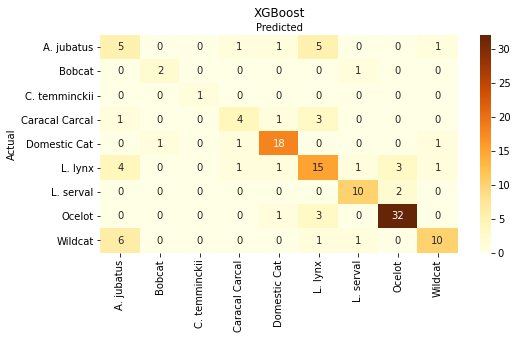

In [85]:
names = sorted(list(set(np.unique(y_test)).union(set(y_pred))))
cnf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names, yticklabels=names,cmap= "YlOrBr")
plt.title('XGBoost')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


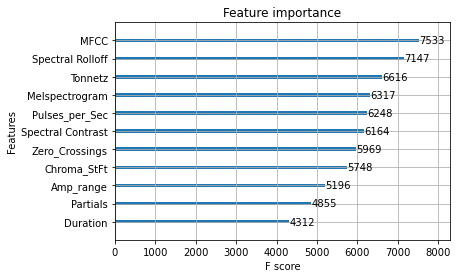

In [86]:
plot_importance(clf)
figsize=(8,4)

## SVM

In [87]:
clf_svc = SVC()

In [88]:
clf_svc.fit(X_train, y_train)

SVC()

In [89]:
clf_svc.score(X_train, y_train)

0.3765432098765432

In [90]:
clf_svc.score(X_test, y_test)

0.34532374100719426

In [91]:
y_pred_svc=clf_svc.predict(X_test)

In [92]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_svc))
print('3. False Positive')
print(set(np.unique(y_pred_svc))-set(np.unique(y_test)))
print('4. False Negative')
print(set(np.unique(y_test))-set(np.unique(y_pred_svc)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
2. Predicted Species
['Domestic Cat' 'L. lynx' 'L. serval' 'Ocelot']
3. False Positive
set()
4. False Negative
{'Caracal Carcal', 'Bobcat', 'C. temminckii', 'Wildcat', 'A. jubatus'}


Accuracy 0.34532374100719426


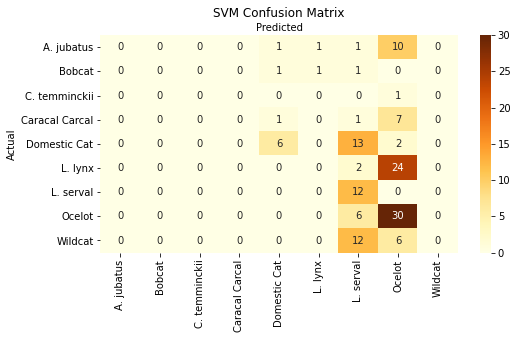

In [93]:
names_svc = sorted(list(set(np.unique(y_test)).union(set(y_pred_svc))))
cnf = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf_svc.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_svc, yticklabels=names_svc,cmap= "YlOrBr")
plt.title('SVM Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



## Naive Bayes

In [94]:
gnb = GaussianNB()

In [95]:
gnb.fit(X_train, y_train)

GaussianNB()

In [96]:
gnb.score(X_train, y_train)

0.6512345679012346

In [97]:
gnb.score(X_test, y_test)

0.5611510791366906

In [98]:
y_pred_nb = gnb.predict(X_test)

In [99]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_nb))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_nb))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_nb)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.5611510791366906


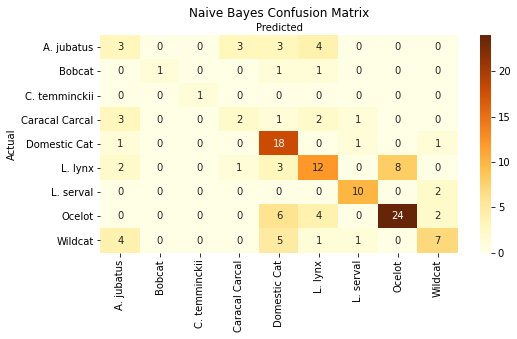

In [100]:
names_nb = sorted(list(set(np.unique(y_test)).union(set(y_pred_nb))))
cnf = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',gnb.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Logistic Regression

In [101]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr')

In [102]:
lr.fit(X_train,y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [103]:
lr.score(X_train, y_train)

0.6111111111111112

In [104]:
lr.score(X_test, y_test)

0.5827338129496403

In [105]:
y_pred_lr = lr.predict(X_test)

In [106]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_lr))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_lr))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_lr)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.5827338129496403


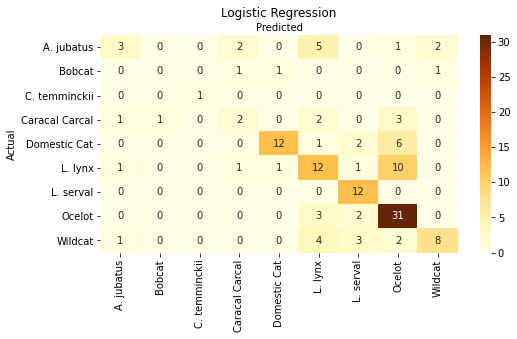

In [107]:
names_lr = sorted(list(set(np.unique(y_test)).union(set(y_pred_lr))))
cnf = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## KNN

In [108]:
knn = KNeighborsClassifier()

In [109]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [110]:
knn.score(X_train, y_train)

0.7993827160493827

In [111]:
knn.score(X_test, y_test)

0.7122302158273381

In [112]:
y_pred_knn = knn.predict(X_test)

In [113]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_knn))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_knn))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_knn)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.7122302158273381


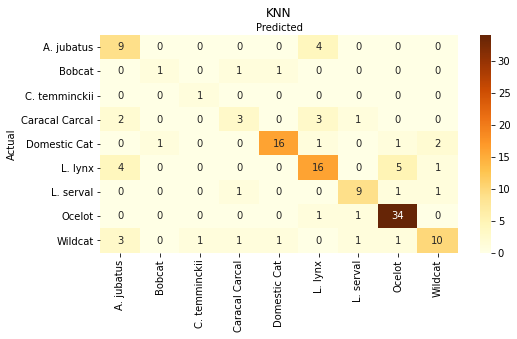

In [114]:
names_knn = sorted(list(set(np.unique(y_test)).union(set(y_pred_knn))))
cnf = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [115]:
cart = DecisionTreeClassifier()

In [116]:
cart.fit(X_train, y_train)

DecisionTreeClassifier()

In [117]:
cart.score(X_train, y_train)

1.0

In [118]:
cart.score(X_test, y_test)

0.6115107913669064

In [119]:
y_pred_cart = cart.predict(X_test)

In [120]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_cart))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_cart))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_cart)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.6115107913669064


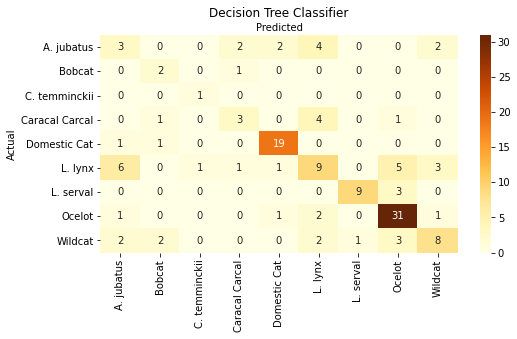

In [121]:
names_cart = sorted(list(set(np.unique(y_test)).union(set(y_pred_cart))))
cnf = confusion_matrix(y_test, y_pred_cart)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',cart.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [122]:
rf = RandomForestClassifier()

In [123]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [124]:
rf.score(X_train, y_train)

1.0

In [125]:
rf.score(X_test, y_test)

0.7410071942446043

In [126]:
y_pred_rf = cart.predict(X_test)

In [127]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_rf))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_rf))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_rf)))

1. Tested Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
2. Predicted Species
['A. jubatus' 'Bobcat' 'C. temminckii' 'Caracal Carcal' 'Domestic Cat'
 'L. lynx' 'L. serval' 'Ocelot' 'Wildcat']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.7410071942446043


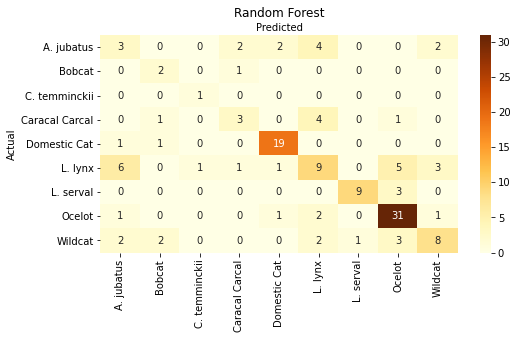

In [128]:
names_rf = sorted(list(set(np.unique(y_test)).union(set(y_pred_rf))))
cnf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf.score(X_test, y_test))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df2['Species'].value_counts()